In [7]:
conda install git

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Python\Anaconda3

  added / updated specs:
    - git


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.13.0               |   py39haa95532_0         923 KB
    git-2.34.1                 |       haa95532_0        50.4 MB
    ------------------------------------------------------------
                                           Total:        51.4 MB

The following NEW packages will be INSTALLED:

  git                pkgs/main/win-64::git-2.34.1-haa95532_0

The following packages will be UPDATED:

  conda                               4.12.0-py39haa95532_0 --> 4.13.0-py39haa95532_0




git-2.34.1           | 50.4 MB   |            |   0% 
git-2.34.1           | 50.4 MB   |            |   0% 
git-2.34.1           | 50.4 MB   |            |   0% 
git-2.34.1           | 50.4 MB   | 1          |   

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
from IPython import display

In [2]:
# We'll use the MNIST to train the generator and discriminator. The generator will generate the
# handwritten digits resembling the MNIST dataset:
(train_images, train_labels), (_, _) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1.0, +1.0]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [3]:
# The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from
# a seed (random noise). We start with a Dense layer that takes this seed as input, then upsample
# it several times until the desired size of 28x28x1:

def generator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
        
    model.add(keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size.
    
    model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [13]:
'''Assertion is this, and assertion! We use assert to be sure a statement is exactly equals to 
what we expect. Here, we check if the output shape is exactly (None, 7, 7, 256), otherwise it
throws an error.'''

'Assertion is this, and assertion! We use assert to be sure a statement is exactly equals to \nwhat we expect. Here, we check if the output shape is exactly (None, 7, 7, 256), otherwise it\nthrows an error.'

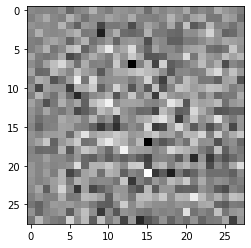

In [4]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [5]:
# The discriminator is a CNN-based image classifier:

def discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, input_shape=[28, 28, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    
    return model

In [6]:
# We use the discriminator to classify images as real or fake. It is trained to output positive
# values for real images, and negative values for fake images.
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00231123]], shape=(1, 1), dtype=float32)


In [7]:
# Define loss function and optimizers for both models:

# This method returns a helper function to compute cross entropy loss
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
# Now we quantify how well the discriminator distinguishes real images from fakes:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
# Now the generator loss, quantifying how well it tricks the discriminator:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# Since the two networks are trained separately, they have separate optimizers:
gener_opt = keras.optimizers.Adam(1e-4)
discr_opt = keras.optimizers.Adam(1e-4)

In [11]:
# We can save and restore our models, which can be helpful for a long running task:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=gener_opt,
                                 discriminator_optimizer=discr_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We'll reuse this seed over time, so it's easier to visualize progress in the GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# tf.function is used for the function to be "compiled":
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        gener_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discr_opt.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produces images for the GIFs as we go:
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save the model every 15 seconds:
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch:
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('Image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

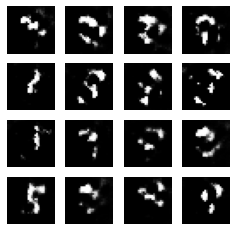

Time for epoch 9 is 2510.070017337799 sec


KeyboardInterrupt: 

In [16]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number:
def display_image(epoch_no):
    return PIL.Image.open('Image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
# Now we use imageio to create an animated gif using the images we saved:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)